#LLM Prompt Template and Chain

##  LangChain Prompt Template and Chain

In this practical, we will explore LangChain, a powerful framework designed to enhance the capabilities of Large Language Models (LLMs) by structuring workflows and simplifying integrations. One key feature of LangChain is Prompt Templates, which allow us to create reusable, flexible, and customizable prompts for interacting with LLMs.

Prompt templates enable you to:

* Define structured inputs for your model.
* Dynamically inject variables into the prompts.
 *Improve consistency and efficiency when working with LLMs.


## Libraries version



langchain==0.3.27

langchain-community==0.3.31

langchain-core==1.0.1

langchain-openai==1.0.1

langchain-text-splitters==0.3.11

langcodes==3.5.0

langsmith==0.4.37

## Install Libraries

In [ ]:
!pip install  langchain openai tiktoken chromadb python-dotenv langchain_community
!pip install  langchain_openai
!pip install docarray
!pip install python-dotenv
!pip install gdown
!pip install  langchain_core

Download the .env into the colab virtual drive

In [ ]:
import gdown

url='https://drive.google.com/file/d/1f-X_cbCcJG0JrJl2FsCNceuA6POKjnXm/view?usp=sdrive_link'
output_path = '.env'
gdown.download(url, output_path, quiet=False,fuzzy=True)

In [ ]:
import os
from dotenv import load_dotenv

# load .env file to environment
load_dotenv()


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## OpenAI LLM parameters


**Core Parameters (Most Essential)**

| Parameter | Type | Description | Example |
|------------|------|--------------|----------|
| **model** | `str` | The name of the OpenAI model to use. | `"gpt-4o-mini"`, `"gpt-4-turbo"`, `"gpt-3.5-turbo"` |
| **openai_api_key** | `str` | Your OpenAI API key (required if not set in environment). | `os.getenv("OPENAI_API_KEY")` |
| **temperature** | `float` | Controls randomness of output. Lower = more deterministic. | `0.0` (deterministic) → `1.0` (creative) |
| **max_tokens** | `int` | Maximum tokens to generate in output. Helps limit response length. | `max_tokens=500` |
| **timeout** | `int` | Max seconds to wait for a response before error. | `timeout=60` |


---

**Behavior & Output Control**

| Parameter | Type | Description | Example |
|------------|------|--------------|----------|
| **top_p** | `float` | Nucleus sampling — controls diversity (alternative to temperature). | `top_p=0.9` |
| **frequency_penalty** | `float` | Reduces repetition of the same lines/phrases. | `frequency_penalty=0.5` |
| **presence_penalty** | `float` | Encourages introducing new topics. | `presence_penalty=0.6` |
| **seed** | `int` | Ensures reproducibility for same inputs (if model supports it). | `seed=42` |
| **response_format** | `str` | Request structured outputs (e.g., `"json_object"`). | `response_format="json_object"` |




In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.7
)

msg = HumanMessage(content="Explain step by step. How old is the president of USA?")
print(llm.invoke([msg]).content)



## Prompt Template

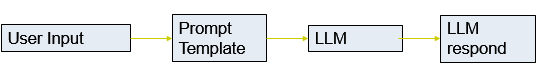

In [ ]:
prompt = PromptTemplate(
    input_variables=["topic"],
    template="Give me a brilliant idea about {topic}."
)

chain = prompt | llm | StrOutputParser()
print(chain.invoke({"topic": "sustainable energy"}))

Now let's extend the same concept for multiple variables as input

In [ ]:
prompt = PromptTemplate(
    input_variables=["topic1", "topic2"],
    template="Give me a brillant idea on {topic1} and {topic2}?",
)

chain = prompt | llm | StrOutputParser()

# Run the chain only specifying the input variable
print(chain.invoke({
    'topic1': "AI",
    'topic2': "NLP"
    }))

## LLM Chains

### LangChain Expression Language (LCEL)

The LangChain Expression Language (LCEL) is a abstraction of some interesting Python concepts into a format that enables a "minimalist" code layer for building chains of LangChain components.



####Pipe Operator

 When we place two classes together like `chain = class_a | class_b` the Python interpreter will check if these classes contain this `__or__` method. If they do then our `|` code will be translated into `chain = class_a.__or__(class_b)`.

In [ ]:

prompt = PromptTemplate(
    input_variables=["topic"],
    template="Give me small report about {topic}."
)



# output parser
output_parser = StrOutputParser()

lcel_chain = prompt | llm | output_parser

# and run
out = lcel_chain.invoke({"topic": "Artificial Intelligence"})
print(out)

### Sequential Chain

A sequential chain works by combining two or more chains. For example you can take the output from one chain and pass it across to next chains sequentially.

Let's try to understand it with the help of an example.

First we create a LLMChain to write outline for a blog topic

Then we create another LLMChain which will take the output from above chain as input and creates a blog detail based on the generated outline

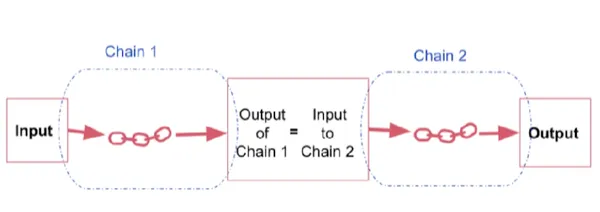

In [ ]:
from pprint import pprint

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence  # , RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

from langchain_community.llms import Ollama

# prompts
prompt1 = PromptTemplate.from_template(
      """Write a blog outline given a topic.
Topic: {topic}"""
)
prompt2 = PromptTemplate.from_template(
  """Write a blog article based on the
{outline}"""
)



# output parser
output_parser = StrOutputParser()

# chain
chain = prompt1 | llm | output_parser
pprint(chain)

# combined chain
combined_chain = RunnableSequence(
    {
        "outline": chain,
    },
    prompt2,
    llm,
    output_parser
)
pprint(combined_chain)

result = combined_chain.invoke({
  "topic": "Deep learning",
})
print(result)

### Router Chain

Router Chain is useful when you have multiple chains for different tasks and you wish to invoke them based on the input provided

For example if you have two LLM chains one good at physics and one good at maths. If you ask a question, the router chain can figure out the topic and send the request to corresponding chain

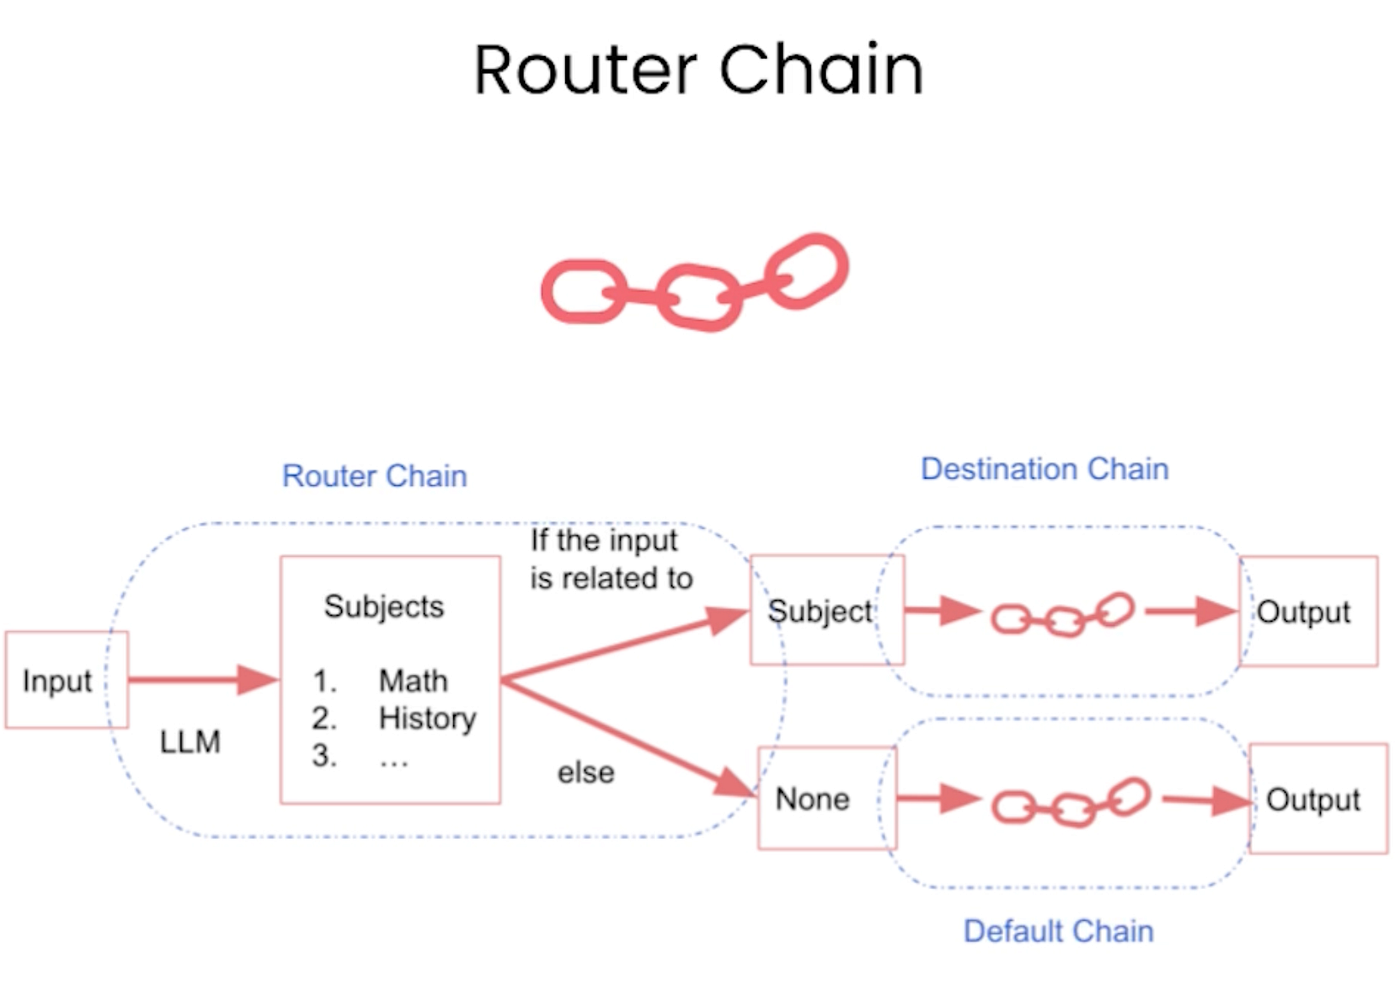

In [ ]:
from langchain_community.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import OpenAIEmbeddings


physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",   # or "text-embedding-3-small"
    openai_api_key=OPENAI_API_KEY
)
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)


def prompt_router(input):
    query_embedding = embeddings.embed_query(input["query"])
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)

In [ ]:
print(chain.invoke("What's a black hole"))

In [ ]:
print(chain.invoke("what is Pythagorean theorem"))


## LlamaIndex Prompt Template and Chain (optional)

### Prompt Template

In [ ]:
!pip install llama-index llama-index-llms-openai
!pip install llama-index-utils-workflow

In [ ]:
mport gdown

url='https://drive.google.com/file/d/1f-X_cbCcJG0JrJl2FsCNceuA6POKjnXm/view?usp=sdrive_link'
output_path = '.env'
gdown.download(url, output_path, quiet=False,fuzzy=True)

In [ ]:
import os
from dotenv import load_dotenv

# load .env file to environment
load_dotenv()


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.llms.openai import OpenAI
import os
# 1. Create an LLM instance
llm = OpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))

# 2. Define a prompt template
prompt = PromptTemplate("Rewrite the following sentence in a more formal tone:\n{sentence}")

# 3. Format the prompt with input
formatted_prompt = prompt.format(sentence="Hey, can you send me the report asap?")

# 4. Call the LLM with the formatted prompt
response = llm.complete(formatted_prompt)

print(response.text)


Simple LLM Chain

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.core.workflow import Workflow, StartEvent, StopEvent, step
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

class OpenAIGenerator(Workflow):
    @step
    async def generate(self, ev: StartEvent) -> StopEvent:
        llm = OpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)
        response = await llm.acomplete(ev.query)
        return StopEvent(result=str(response))

# Instantiate and run
w = OpenAIGenerator(timeout=10, verbose=False)

# Because it's async, we must run it inside an async context
import asyncio
async def main():
    result = await w.run(query="What's LlamaIndex?")
    print(result)

await main()


In [ ]:
import os
from dotenv import load_dotenv

# load .env file to environment
load_dotenv()


OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

from llama_index.llms.openai import OpenAI
from llama_index.core.workflow import Workflow, StartEvent, Event, StopEvent, step

class MultiStepGenerator(Workflow):

    @step
    async def process_text(self, ev: StartEvent) -> StopEvent:
        llm = OpenAI(model="gpt-4o")

        # Step 1: Rewrite
        query = ev.data.get("query", "")
        rewrite_prompt = f"Rewrite the following text in a professional tone:\n\n{query}"
        rewrite_response = await llm.acomplete(rewrite_prompt)
        rewritten_text = str(rewrite_response)

        # Step 2: Summarize
        summarize_prompt = f"Summarize the following text in 2 sentences:\n\n{rewritten_text}"
        summarize_response = await llm.acomplete(summarize_prompt)
        summarized_text = str(summarize_response)

        # Step 3: Translate
        translate_prompt = f"Translate the following text into French:\n\n{summarized_text}"
        translate_response = await llm.acomplete(translate_prompt)
        translated_text = str(translate_response)

        return StopEvent(result={
            "rewrite": rewritten_text,
            "summarize": summarized_text,
            "translate": translated_text
        })

# Initialize workflow
wf = MultiStepGenerator(
    timeout=60,
    verbose=True
)

# Run workflow
result = await wf.run(data={"query": "Hey, can you send me the report asap? It's very important for our team."})

print("🔍 Debug - Result type:", type(result))
print("🔍 Debug - Result content:", result)

print("✅ Final Output:\n", result["translate"])
